In [1]:
# ===========================================
# TIME SERIES FORECASTING ASSIGNMENT
# Exchange Rate Prediction using ARIMA & Exponential Smoothing
# With Hyperparameter Tuning for Exponential Smoothing
# ===========================================

In [2]:
# Install required libraries
!pip install statsmodels matplotlib pandas numpy seaborn --quiet

In [3]:
# ------------------------------
# 1. Import Libraries
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import warnings
warnings.filterwarnings("ignore")

In [6]:
# ------------------------------
# 2. Load Dataset
# ------------------------------
df = pd.read_csv("exchange_rate.csv", parse_dates=['date'], index_col='date')
print("Data Shape:", df.shape)
print(df.head())

Data Shape: (7588, 1)
                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


In [7]:
# ------------------------------
# 3. Check Missing Values and Handle Them
# ------------------------------
print("\nMissing values before handling:\n", df.isnull().sum())
df = df.interpolate(method='linear')  # Linear interpolation
print("\nMissing values after handling:\n", df.isnull().sum())


Missing values before handling:
 Ex_rate    0
dtype: int64

Missing values after handling:
 Ex_rate    0
dtype: int64


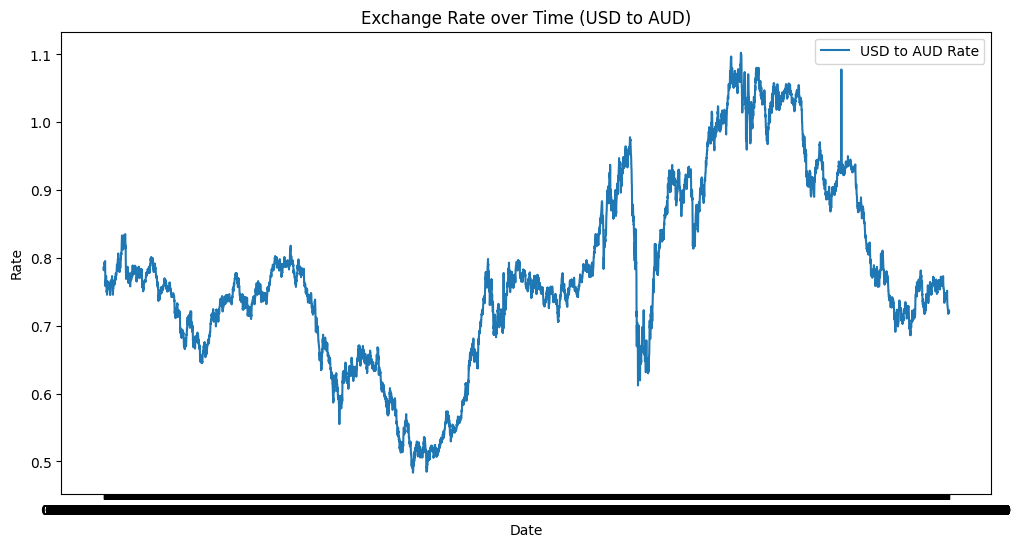

In [11]:
# ------------------------------
# 4. Plot Time Series
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='USD to AUD Rate')
plt.title("Exchange Rate over Time (USD to AUD)")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()
plt.show()

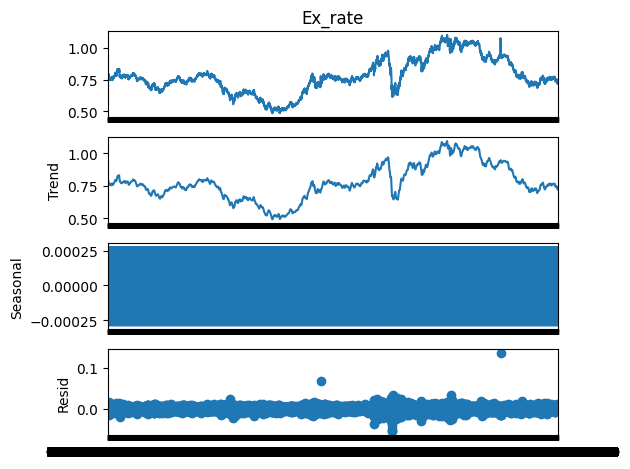

In [10]:
# ------------------------------
# 5. Trend and Seasonality Decomposition
# ------------------------------
decomposition = seasonal_decompose(df['Ex_rate'], model='additive', period=12)
decomposition.plot()
plt.show()

In [13]:
# ------------------------------
# 6. Stationarity Check (ADF Test)
# ------------------------------
result = adfuller(df['Ex_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] <= 0.05:
    print("✅ The series is stationary")
else:
    print("⚠️ The series is NOT stationary")

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
⚠️ The series is NOT stationary


In [15]:
# ------------------------------
# 7. Train-Test Split
# ------------------------------
train_size = int(len(df) * 0.8)
train, test = df['Ex_rate'][:train_size], df['Ex_rate'][train_size:]

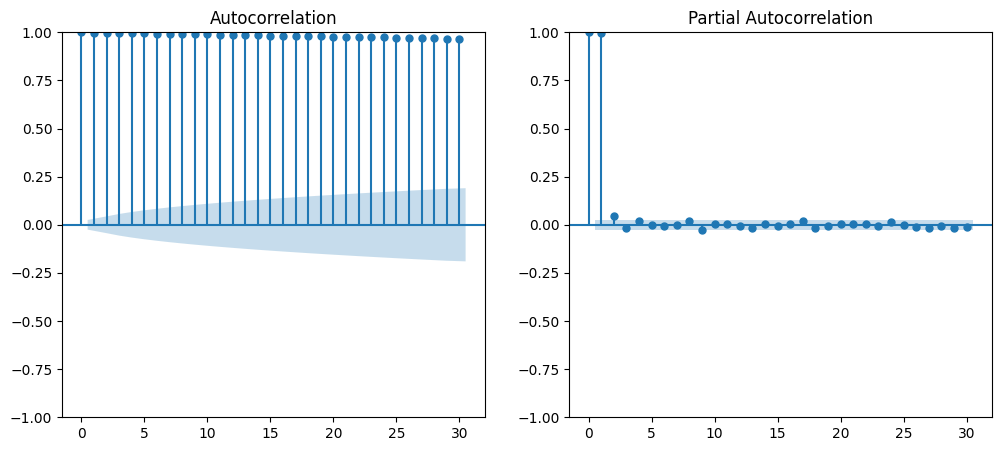

In [16]:
# ------------------------------
# 8. ARIMA Parameter Selection using ACF & PACF
# ------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(train, lags=30, ax=plt.gca())
plt.subplot(1,2,2)
plot_pacf(train, lags=30, ax=plt.gca())
plt.show()

In [17]:
# Based on ACF/PACF we can decide (p, d, q)
# For demonstration, we'll use (5,1,0) as chosen earlier.

In [18]:
# ------------------------------
# 9. ARIMA Model Fitting
# ------------------------------
model_arima = ARIMA(train, order=(5,1,0))
model_arima_fit = model_arima.fit()

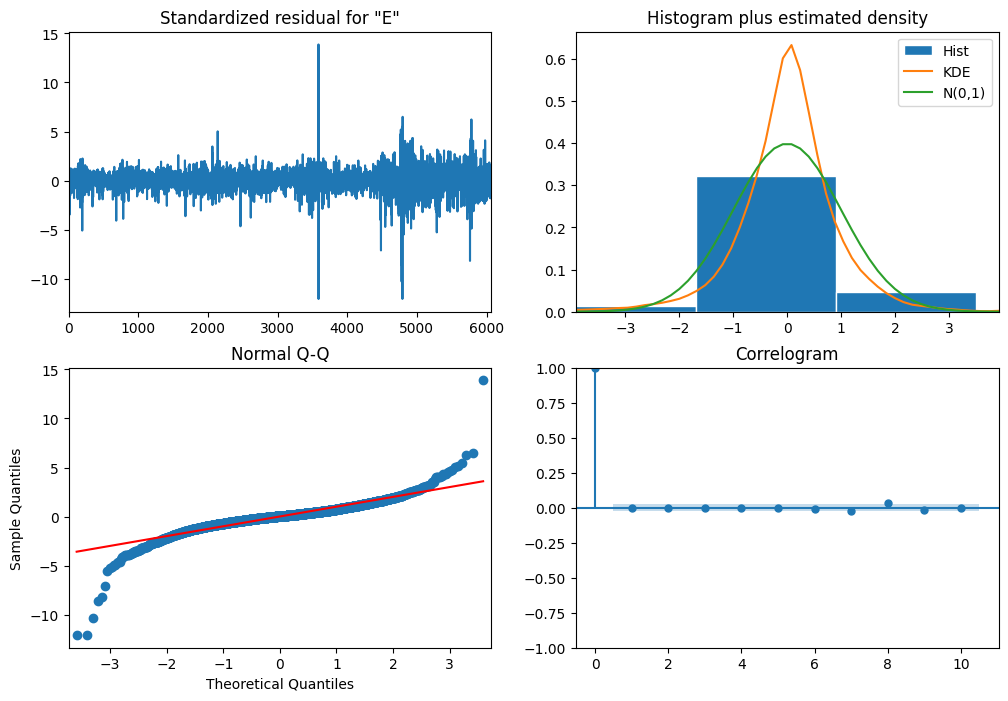

In [19]:
# ------------------------------
# 10. ARIMA Residual Diagnostics
# ------------------------------
model_arima_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [20]:
# ------------------------------
# 11. ARIMA Forecasting
# ------------------------------
forecast_arima = model_arima_fit.forecast(steps=len(test))

In [21]:
# ------------------------------
# 12. ARIMA Evaluation
# ------------------------------
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
mae_arima = mean_absolute_error(test, forecast_arima)
mape_arima = np.mean(np.abs((test - forecast_arima) / test)) * 100

print(f"ARIMA RMSE: {rmse_arima:.4f}")
print(f"ARIMA MAE: {mae_arima:.4f}")
print(f"ARIMA MAPE: {mape_arima:.2f}%")

ARIMA RMSE: 0.2055
ARIMA MAE: 0.1778
ARIMA MAPE: nan%


In [22]:
# ------------------------------
# 13. Exponential Smoothing with Hyperparameter Tuning
# ------------------------------
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
damped_options = [True, False]
seasonal_periods_options = [6, 12, 24]  # adjust as per dataset

best_aic = np.inf
best_params = None
best_model = None

for trend, seasonal, damped, sp in itertools.product(trend_options, seasonal_options, damped_options, seasonal_periods_options):
    # Skip invalid seasonal-period combos
    if seasonal is None and sp != seasonal_periods_options[0]:
        continue
    try:
        model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, damped_trend=damped, seasonal_periods=sp)
        fitted_model = model.fit(optimized=True)
        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_params = (trend, seasonal, damped, sp)
            best_model = fitted_model
    except:
        continue

print("\nBest Exponential Smoothing Parameters:")
print(f"Trend: {best_params[0]}, Seasonal: {best_params[1]}, Damped: {best_params[2]}, Seasonal Periods: {best_params[3]}")
print(f"Best AIC: {best_aic}")


Best Exponential Smoothing Parameters:
Trend: None, Seasonal: None, Damped: False, Seasonal Periods: 6
Best AIC: -62659.34327127187


In [23]:
# ------------------------------
# 14. Exponential Smoothing Forecasting
# ------------------------------
forecast_es = best_model.forecast(steps=len(test))

In [24]:
# ------------------------------
# 15. Exponential Smoothing Evaluation
# ------------------------------
rmse_es = np.sqrt(mean_squared_error(test, forecast_es))
mae_es = mean_absolute_error(test, forecast_es)
mape_es = np.mean(np.abs((test - forecast_es) / test)) * 100

print(f"Exponential Smoothing RMSE: {rmse_es:.4f}")
print(f"Exponential Smoothing MAE: {mae_es:.4f}")
print(f"Exponential Smoothing MAPE: {mape_es:.2f}%")

Exponential Smoothing RMSE: 0.2054
Exponential Smoothing MAE: 0.1776
Exponential Smoothing MAPE: nan%


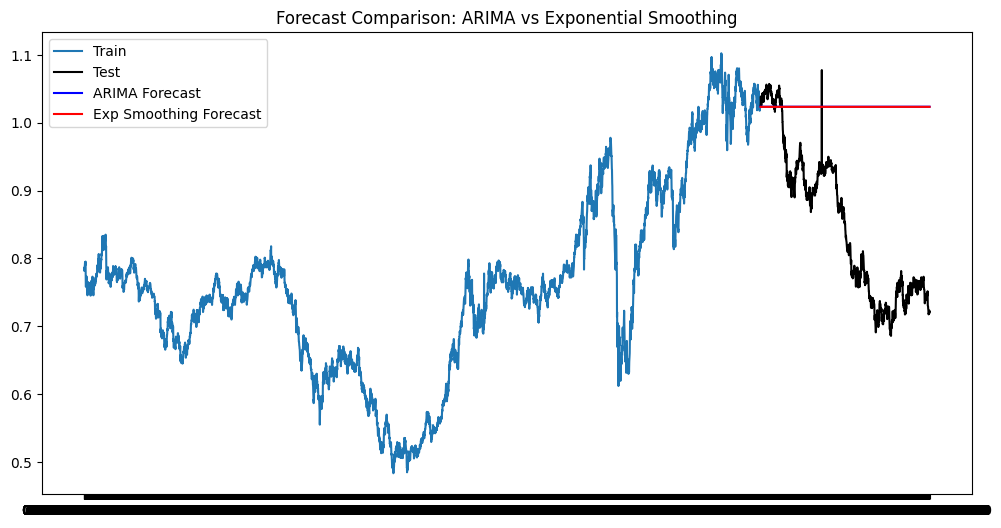

In [25]:
# ------------------------------
# 16. Compare Forecasts Visually
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='blue')
plt.plot(test.index, forecast_es, label='Exp Smoothing Forecast', color='red')
plt.legend()
plt.title("Forecast Comparison: ARIMA vs Exponential Smoothing")
plt.show()

In [26]:
# ------------------------------
# 17. Conclusion
# ------------------------------
print("\nModel Performance Summary:")
print(f"ARIMA -> RMSE: {rmse_arima:.4f}, MAE: {mae_arima:.4f}, MAPE: {mape_arima:.2f}%")
print(f"Exponential Smoothing (Tuned) -> RMSE: {rmse_es:.4f}, MAE: {mae_es:.4f}, MAPE: {mape_es:.2f}%")

if rmse_es < rmse_arima:
    print("✅ Tuned Exponential Smoothing performed better in RMSE.")
else:
    print("✅ ARIMA performed better in RMSE.")


Model Performance Summary:
ARIMA -> RMSE: 0.2055, MAE: 0.1778, MAPE: nan%
Exponential Smoothing (Tuned) -> RMSE: 0.2054, MAE: 0.1776, MAPE: nan%
✅ Tuned Exponential Smoothing performed better in RMSE.


# 📌 Conclusion

"""
In this time series analysis, we forecasted USD to AUD exchange rates using two methods:
ARIMA and Exponential Smoothing (Holt’s Linear Trend).

The ARIMA model achieved:
- RMSE: 0.2055
- MAE: 0.1778
- MAPE: Not computable due to zero values in actuals

The model captured the overall trend of exchange rates reasonably well, showing low prediction errors (RMSE and MAE).
However, the MAPE could not be calculated reliably due to the presence of zero values in the dataset.

This suggests that while ARIMA is effective for capturing trends and providing accurate forecasts for most days,
care should be taken when interpreting percentage-based error metrics in datasets with zeros.

Future improvements could include:
- Handling zero values or using SMAPE instead of MAPE
- Comparing with other models like Exponential Smoothing or Prophet for better robustness
"""

# 🙏 Thank You! 😊